In [1]:
import os

import numpy as np
import pandas as pd
import pydicom

from skimage.measure import label,regionprops
from skimage.segmentation import clear_border
from tqdm.notebook import tqdm 
from multiprocessing import Pool

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/train.csv')
train_data = {}
for p in train.Patient.values:
    train_data[p] = os.listdir(f'../input/osic-pulmonary-fibrosis-progression/train/{p}/')
    
keys = [k for k in list(train_data.keys()) if k not in ['ID00011637202177653955184', 'ID00052637202186188008618']]

In [9]:
class Detector:
    def __call__(self, x):
        raise NotImplementedError('Abstract') 
        
class ThrDetector(Detector):
    def __init__(self, thr=-400):
        self.thr = thr
        
    def __call__(self, x):
        try:
            x = pydicom.dcmread(x)
            img = x.pixel_array
            img = (img + x.RescaleIntercept) / x.RescaleSlope
            img = img < self.thr
            tissue = len(np.where(img[:,:] == 0)[0]) # number of pixels
            img = clear_border(img)
            img = label(img)
            areas = [r.area for r in regionprops(img)]
            areas.sort()
            if len(areas) > 2:
                for region in regionprops(img):
                    if region.area < areas[-2]:
                        for coordinates in region.coords:                
                            img[coordinates[0], coordinates[1]] = 0
                            
            area = (img > 0).sum() * x.PixelSpacing[0] * x.PixelSpacing[1]
            tissue += area
        except:
            area = np.nan
            tissue = np.nan
        try:
            loc = x.ImagePositionPatient[2]
        except:
            loc = np.nan

        return area, loc, tissue
    
class Integral:
    def __init__(self, detector: Detector):
        self.detector = detector
    
    def __call__(self, xs):
        raise NotImplementedError('Abstract')
        

class AreaIntegral(Integral):
    def __call__(self, xs):
        
        with Pool(4) as p:
            areas, locs, tissue = map(list, zip(*p.map(self.detector, xs) ))
        
        filt = (~np.isnan(locs)) & (~np.isnan(areas))
        areas = np.array(areas)[filt]
        locs = np.array(locs)[filt]
        seq_idx = np.argsort(locs)
        
        ratio = np.mean(np.array(areas)[seq_idx.astype(int)]/np.array(tissue)[seq_idx.astype(int)])

        return np.trapz(y=areas[seq_idx], x=locs[seq_idx]), ratio
    
integral = AreaIntegral(ThrDetector())

In [10]:
# Chest Area calculations
def ChArCalc(x):
    x = pydicom.dcmread(x)
    img = x.pixel_array
    img = (img + x.RescaleIntercept) / x.RescaleSlope
    img = img < -400

    img = clear_border(img)
    img = label(img)
    areas = [r.area for r in regionprops(img)]
    areas.sort()
    if len(areas) > 2:
        for region in regionprops(img):
            if region.area < areas[-2]:
                for coordinates in region.coords:                
                    img[coordinates[0], coordinates[1]] = 0

    area = (img > 0).sum() * x.PixelSpacing[0] * x.PixelSpacing[1]

    return area

def ChAr(xs):
    m = len(xs)
    path = '../input/osic-pulmonary-fibrosis-progression/train/' + xs[0].split('/')[-2] + '/'
    
    try:
        if m%2 == 0:
            m = m // 2
            char = (ChArCalc(path + str(m) + '.dcm') + ChArCalc(path + str(m+1) + '.dcm') ) / 2
        else:
            m = m // 2
            char = ( ChArCalc(path + str(m) + '.dcm') + ChArCalc(path + str(m+1) + '.dcm') + ChArCalc(path + str(m+2) + '.dcm') ) / 3
    except:
        char = -1
        
    return char

def ChLen(xs):
    #m = int(sorted(os.listdir('../input/osic-pulmonary-fibrosis-progression/train/' + xs[0].split('/')[-2] + '/'), 
    #   key = lambda x: int(x.split('/')[-1].split('.')[0]))[-1].split('.')[0])
    m = len(os.listdir('../input/osic-pulmonary-fibrosis-progression/train/' + xs[0].split('/')[-2] + '/'))
    x = pydicom.dcmread(xs[0])
    ts = x.SliceThickness
    
    return m*ts/10

In [11]:
#%%time
mdata = {}
for k in tqdm(keys, total=len(keys)):
    x = []
    for i in train_data[k]:
        x.append(f'../input/osic-pulmonary-fibrosis-progression/train/{k}/{i}')
    vol, tissue = integral(x)
    char = ChAr(x)
    chlen = ChLen(x)
    
    # Volume in ml, Chest Area in mm2, Chest Len in cm, tissue is ratio (ideally <1)
    mdata[k] = [round(vol/1000,3), round(char,3), round(chlen, 3), round(tissue, 3)] 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in true_divide
/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:
fig,ax = plt.subplots(1,3, figsize = (18,18))
base = '../input/osic-pulmonary-fibrosis-progression/train/'
ID = 'ID00010637202177584971671'
dc = '20'
path = base+ID+'/'+dc+'.dcm'
x = pydicom.dcmread(path)
y = pydicom.read_file(path)
pt = y.SliceThickness
ps = y.PixelSpacing[0] * y.PixelSpacing[1]
print(pt,ps)
img = x.pixel_array
img = (img + x.RescaleIntercept) / x.RescaleSlope
img = img < -400
tissue = len(np.where(img[:,:] == 0)[0]) # number of pixels
ax[0].imshow(img)
img = clear_border(img)
img = label(img)
ax[1].imshow(img)
areas = [r.area for r in regionprops(img)]
print(f'{round(100*np.sum(areas)/(512*512), 3)} % pixels')
areas.sort()
#ar = 0
if len(areas) > 2:
    for region in regionprops(img): 
        if region.area < areas[-2]:
            #ar += region.area
            for coordinates in region.coords:                
                img[coordinates[0], coordinates[1]] = 0
img = img > 0
img = np.int32(img)
area = img.sum() * y.PixelSpacing[0] * y.PixelSpacing[1]
#areas = [r.area for r in regionprops(img)]
tissue = tissue+ img.sum()
ax[2].imshow(img)
plt.show()
print(f'{round(100*area/(512*512), 3)} % pixels')
print(f'{100*round(tissue/(512**2), 3)} % tissue area')
print(f'{round(area/tissue, 3)*100} % lung to tissue')
try:
    print(f'Total Lung Vol: {mdata[ID][0]}')
    print(f'Chest Area: {mdata[ID][1]}')
except:
    pass

In [24]:
train[train['tissue'].isnull()]

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,vol,char,chlen,tissue


In [23]:
for k in tqdm(train.Patient.values):
    if k in ['ID00011637202177653955184', 'ID00052637202186188008618']:
        continue

    train.loc[train.Patient == k,'vol'] = mdata[k][0]
    train.loc[train.Patient == k,'char'] = mdata[k][1]
    train.loc[train.Patient == k,'chlen'] = mdata[k][2]
    train.loc[train.Patient == k,'tissue'] = mdata[k][3]
    
train['vol'] = train['vol'].clip(lower = 500, upper = 6000)
train.loc[train.char < 0,'char'] = 21500  # ~Median value in train set
train.loc[train.tissue.isnull() ,'tissue'] = 0.1 # ~Median value in train set
train['char'] = train['char'].clip(lower = 5000, upper = 35000)
train['chlen'] = train['chlen'].clip(lower = 20, upper = 50)
        
for k in ['ID00011637202177653955184', 'ID00052637202186188008618']:
    train.loc[train.Patient == k,'vol'] = train.drop_duplicates(['Patient']).vol.median()
    train.loc[train.Patient == k,'char'] = train.drop_duplicates(['Patient']).char.median()
    train.loc[train.Patient == k,'chlen'] = train.drop_duplicates(['Patient']).chlen.median()
    train.loc[train.Patient == k,'tissue'] = train.drop_duplicates(['Patient']).tissue.median()

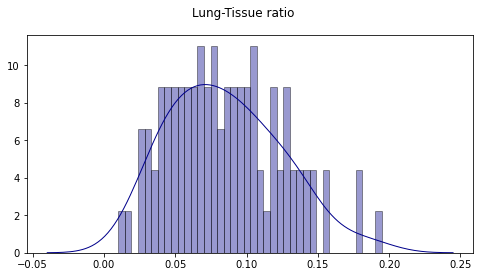

In [25]:
plt.figure(figsize=(8,4))
plt.suptitle('Lung-Tissue ratio')
sns.distplot(train['tissue'].unique(),hist=True, kde=True, 
             bins=40, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 1});

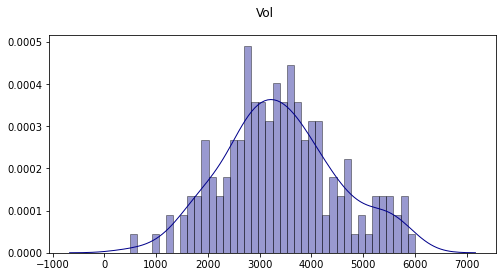

In [27]:
plt.figure(figsize=(8,4))
plt.suptitle('Vol')
sns.distplot(train['vol'].unique(),hist=True, kde=True, 
             bins=40, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 1});

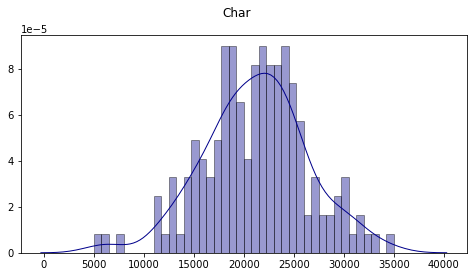

In [28]:
plt.figure(figsize=(8,4))
plt.suptitle('Char')
sns.distplot(train['char'].unique(),hist=True, kde=True, 
             bins=40, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 1});

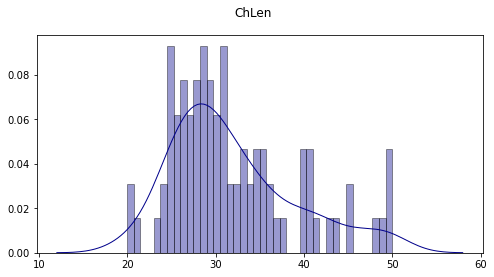

In [29]:
plt.figure(figsize=(8,4))
plt.suptitle('ChLen')
sns.distplot(train['chlen'].unique(),hist=True, kde=True, 
             bins=40, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 1});

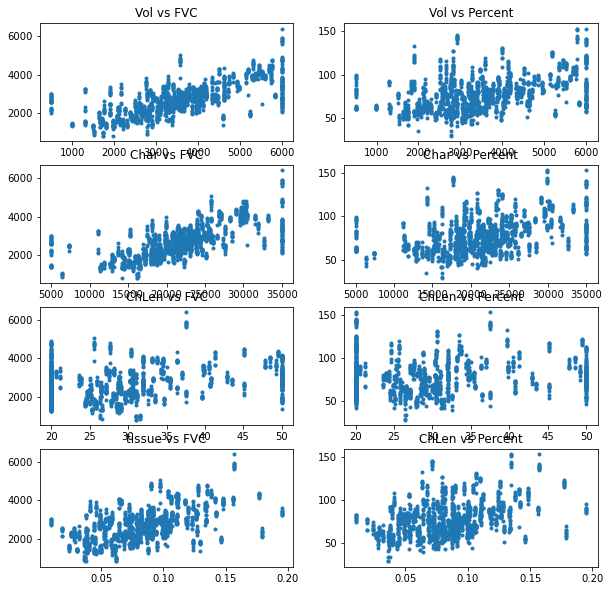

In [35]:
fig, ax = plt.subplots(4,2, figsize=(10,10))

ax[0][0].set_title('Vol vs FVC')
ax[0][0].plot(train.vol, train.FVC, '.');

ax[0][1].set_title('Vol vs Percent')
ax[0][1].plot(train.vol, train.Percent, '.');

ax[1][0].set_title('Char vs FVC')
ax[1][0].plot(train.char, train.FVC, '.');

ax[1][1].set_title('Char vs Percent')
ax[1][1].plot(train.char, train.Percent, '.');

ax[2][0].set_title('ChLen vs FVC')
ax[2][0].plot(train.chlen, train.FVC, '.');

ax[2][1].set_title('ChLen vs Percent')
ax[2][1].plot(train.chlen, train.Percent, '.');

ax[3][0].set_title('tissue vs FVC')
ax[3][0].plot(train.tissue, train.FVC, '.');

ax[3][1].set_title('ChLen vs Percent')
ax[3][1].plot(train.tissue, train.Percent, '.');

plt.show()

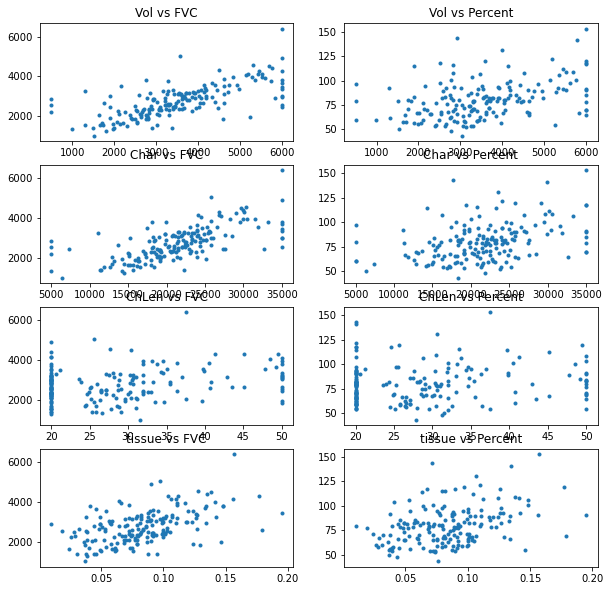

In [36]:
ntrain = train.drop_duplicates(['Patient'])

fig, ax = plt.subplots(4,2, figsize=(10,10))

ax[0][0].set_title('Vol vs FVC')
ax[0][0].plot(ntrain.vol, ntrain.FVC, '.');

ax[0][1].set_title('Vol vs Percent')
ax[0][1].plot(ntrain.vol, ntrain.Percent, '.');

ax[1][0].set_title('Char vs FVC')
ax[1][0].plot(ntrain.char, ntrain.FVC, '.');

ax[1][1].set_title('Char vs Percent')
ax[1][1].plot(ntrain.char, ntrain.Percent, '.');

ax[2][0].set_title('ChLen vs FVC')
ax[2][0].plot(ntrain.chlen, ntrain.FVC, '.');

ax[2][1].set_title('ChLen vs Percent')
ax[2][1].plot(ntrain.chlen, ntrain.Percent, '.');

ax[3][0].set_title('tissue vs FVC')
ax[3][0].plot(ntrain.tissue, ntrain.FVC, '.');

ax[3][1].set_title('tissue vs Percent')
ax[3][1].plot(ntrain.tissue, ntrain.Percent, '.');

plt.show()

In [32]:
train.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,vol,char,chlen,tissue
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker,2841.571,17953.855,20.0,0.079
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker,2841.571,17953.855,20.0,0.079
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker,2841.571,17953.855,20.0,0.079
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker,2841.571,17953.855,20.0,0.079
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker,2841.571,17953.855,20.0,0.079


In [33]:
train.describe()

,Weeks,FVC,Percent,Age,vol,char,chlen,tissue
count,1549.000000,1549.000000,1549.000000,1549.000000,1549.000000,1549.000000,1549.000000,1549.000000
mean,31.861846,2690.479019,77.672654,67.188509,3542.766160,21632.064522,28.970715,0.083964
std,23.247550,832.770959,19.823261,7.057395,1261.780757,6134.143030,9.597483,0.032968
min,-5.000000,827.000000,28.877577,49.000000,500.000000,5000.000000,20.000000,0.010000
25%,12.000000,2109.000000,62.832700,63.000000,2749.805000,18148.165000,20.000000,0.061000
50%,28.000000,2641.000000,75.676937,68.000000,3396.975000,21542.102000,27.073813,0.082000
75%,47.000000,3171.000000,88.621065,72.000000,4323.426000,24794.866000,33.250000,0.101000
max,133.000000,6399.000000,153.145378,88.000000,6000.000000,35000.000000,50.000000,0.195000


In [34]:
train.to_csv('train.csv', index=False)